In [1]:
import pandas as pd
import numpy as np
import ast
import csv
import time
import random
import seaborn as sns

from operator import itemgetter
import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt

In [2]:
users=np.zeros((40000,1))

In [3]:
users.shape

(40000, 1)

In [4]:
user_friends={}
user_tags={}
max_friends=0
min_friends=200000
def hasMoreTags(s):
    return s[-1]!=']'

# Generate User: Tags dict

In [5]:
start=time.time()
with open('data.csv', 'r') as infile:
    reader = csv.reader(infile)
    count=-1
    
    for row in reader:
        #print(row[:7])
        count += 1
        if count == 0:
            continue
        id=row[0]
        #print(count)
        users[count-1][0]=id
        screenName=row[1]
        
        many_tags=hasMoreTags(row[2])
        
        offset=0
        #print('{} originally'.format(row[2]))
        #print(row[3])
        if many_tags:
            this_tags=[]
            for j in range(20):
                this_tags.append(row[2+j].strip('[]').strip(''))
                if row[2+j][-1]==']':
                    break
            #print('{} many tags'.format(this_tags))
            user_tags[id]=this_tags
            offset=len(this_tags)-1
            #print(offset)
        else:
            user_tags[id]=row[2].strip('[]').strip('')
            
        #followersCount=row[4]
        #print(offset)
        friendsCount=int(row[5+offset])
        #print(row[5+offset])
        max_friends=max(max_friends,friendsCount)
        min_friends=min(min_friends,friendsCount)
        friends=row[9+offset:]
        friends[0]=friends[0].strip('[]')
        friends[-1]=friends[-1].strip('[]')
        friends=[i.replace('"', '') for i in friends]
        friends=[i.strip() for i in friends]
        user_friends[id]=friends 
        #print("{} : {}".format(count, friends))
end=time.time()
print('{} seconds'.format(end-start))

13.802095651626587 seconds


In [6]:
print(max_friends)
print(min_friends)


238749
101


# Generate/Read all tags

In [7]:
import re
def remove_hashtag(raw_str):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",raw_str).split())

In [8]:
try:
    all_tags=pd.read_csv('all_tags_saved.csv')
except:
    all_tags=set()

    for u in user_tags:
        tags=user_tags[u]

        if type(tags) == str:
            all_tags.add(remove_hashtag(tags))
        else:
            for tag in tags:
                all_tags.add(remove_hashtag(tag))

    pd.DataFrame(list(all_tags)).to_csv('all_tags_saved.csv')

In [9]:
len(all_tags)

128

# Generate Tag: User dict

In [10]:
tag_users={}

In [11]:
for u in user_tags:
    tags=user_tags[u]
    if type(tags)==str:
        normalized_tag=remove_hashtag(tags)
        if normalized_tag in tag_users:
            cur_tags=tag_users[normalized_tag]
            cur_tags.append(u)
            tag_users[normalized_tag]=cur_tags
        else:
            cur_tags=[]
            cur_tags.append(u)
            tag_users[normalized_tag]=cur_tags
    else:
        for tag in tags:
            normalized_tag=remove_hashtag(tag)
            if normalized_tag in tag_users:
                cur_tags=tag_users[normalized_tag]
                cur_tags.append(u)
                tag_users[normalized_tag]=cur_tags
            else:
                cur_tags=[]
                cur_tags.append(u)
                tag_users[normalized_tag]=cur_tags

In [12]:
print(len(tag_users))

128


In [13]:
x=list(tag_users.keys())
y=[len(item) for item in tag_users.values()]

tag_nums=pd.DataFrame({'tags':x,'num':y})

# Sort by the num of each tag
sorted_tag_nums=tag_nums.sort_values(by=['num'], ascending=[0])

In [14]:
sorted_tag_nums[:10]

,tags,num
0,nationaldogday,30513
17,respecttylerjoseph,6054
2,gloryoutnow,600
8,backtohogwarts,310
1,narcos,269
76,steve rogers,211
31,louisweloveyou,142
24,bournemouth,130
69,bundesliga,122
27,harry potter,103


In [15]:
sorted_x=sorted_tag_nums['tags'][:5]
sorted_y=sorted_tag_nums['num'][:5]

In [16]:
list(sorted_x)

['nationaldogday',
 'respecttylerjoseph',
 'gloryoutnow',
 'backtohogwarts',
 'narcos']

c:\users\astr010gos\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


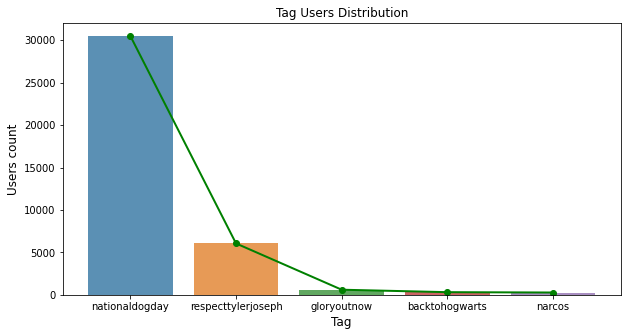

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(sorted_x, sorted_y, alpha=0.8)

plt.title('Tag Users Distribution')

plt.ylabel('Users count', fontsize=12)
plt.xlabel('Tag', fontsize=12)
plt.plot(sorted_x, sorted_y,'go-', label='line 1', linewidth=2)

plt.savefig('Graphs/tag_users_distribution.png')

In [18]:
# Generate the nodes and edges
nodes=user_friends.keys()
len(nodes)


40000

edges = [(uid, fid) for uid in user_friends for fid in user_friends[uid]]

G = nx.Graph
G.add_edges_from(edges)

pos = nx.circular_layout(G)

nx.draw_networkx(G,pos)
plt.title("Twitter Grapy")

plt.show()


In [19]:
# 输出nodelist
node_list=list(nodes)
with open('nodelist.txt', 'w') as filehandle:
    for listitem in node_list:
        filehandle.write('%s\n' % listitem)

In [20]:
# 输出edgelist
edges = [(uid, fid) for uid in user_friends for fid in user_friends[uid]]
with open('edgelist.txt', 'w') as filehandle:
    for listitem in edges:
        filehandle.write('%s\n' % listitem)

TypeError: not all arguments converted during string formatting

In [25]:
def calculate_shortest_dist(this_tag, k_nodes):
    count=1
    size_k=len(k_nodes)
    for index_a in range(size_k):

        no_paths=[]
        shortest_path_list=[]
        shortest_dist=[]

        for index_b in range(index_a+1, size_k):
            a=k_nodes[index_a]
            b=k_nodes[index_b]
            
            try:
                s_path=nx.shortest_path_length(G,source=a,target=b)
                shortest_path_list.append((a,b,s_path))
                shortest_dist.append(s_path)

            except:
                no_paths.append((a,b))

        with open('%s_shortest_path.txt'%this_tag,'a+') as fp:
            fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

        with open('%s_shortest_path.txt'%this_tag,'a+') as fp:
            fp.write('\n')

        with open('%s_no_path.txt'%this_tag,'a+') as fp:
            fp.write('\n'.join('%s %s'%x for x in no_paths))

        with open('%s_no_path.txt'%this_tag,'a+') as fp:
            fp.write('\n')
  
        with open('%s_shortest_dist.txt'%this_tag,'a+') as fp:
            fp.write('\n'.join('%s'%x for x in shortest_dist))

        with open('%s_shortest_dist.txt'%this_tag,'a+') as fp:
            fp.write('\n')

        #print('Finished {} node'.format(count))
        count+=1

# Create the graph

In [21]:
#G=nx.read_edgelist('edgelist.txt',create_using=nx.Graph(),nodetype=int)
G=nx.read_edgelist('edgelist_sim.txt',create_using=nx.Graph(),nodetype=int)
nx.write_gpickle(G,"test.gpickle")
# Read from pickle
#G=nx.read_gpickle("test.gpickle")

In [22]:
########### Print the summary of the graph ###########
print(nx.info(G))

Graph with 392620 nodes and 508406 edges


# Calculate the shortest path without Tags

In [26]:
node_list=[line.rstrip('\n') for line in open('nodelist.txt')]

k=5000
k_nodes=set()

while len(k_nodes)<k:
    n1=random.choice(node_list)
    if n1 not in k_nodes:
        k_nodes.add(n1)

print('Finished sampling {} nodes'.format(k))

k_nodes=list(k_nodes)

count=1
pairs_count=0

for index_a in range(k):
    no_paths=[]
    shortest_path_list=[]
    shortest_dist=[]

    for index_b in range(index_a+1,k):
        pairs_count+=1
        a=k_nodes[index_a]
        b=k_nodes[index_b]

        try:
            s_path=nx.shortest_path_length(G,a,b)
            shortest_path_list.append((a,b,s_path))
            shortest_dist.append(s_path)

        except:
            no_paths.append((a,b))

    with open('real_%s_shortest_path.txt'%k,'a+') as fp:
        fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

    with open('real_%s_no_path.txt'%k,'a+') as fp:
        fp.write('\n'.join('%s %s'%x for x in no_paths))

    with open('real_%s_shortest_dist.txt'%k,'a+') as fp:
        fp.write('\n'.join('%s'%x for x in shortest_dist))

    print('Finished {} node'.format(count))
    count+=1

Finished sampling 5000 nodes
Finished 1 node
Finished 2 node
Finished 3 node
Finished 4 node
Finished 5 node
Finished 6 node
Finished 7 node
Finished 8 node
Finished 9 node
Finished 10 node
Finished 11 node
Finished 12 node
Finished 13 node
Finished 14 node
Finished 15 node
Finished 16 node
Finished 17 node
Finished 18 node
Finished 19 node
Finished 20 node
Finished 21 node
Finished 22 node
Finished 23 node
Finished 24 node
Finished 25 node
Finished 26 node
Finished 27 node
Finished 28 node
Finished 29 node
Finished 30 node
Finished 31 node
Finished 32 node
Finished 33 node
Finished 34 node
Finished 35 node
Finished 36 node
Finished 37 node
Finished 38 node
Finished 39 node
Finished 40 node
Finished 41 node
Finished 42 node
Finished 43 node
Finished 44 node
Finished 45 node
Finished 46 node
Finished 47 node
Finished 48 node
Finished 49 node
Finished 50 node
Finished 51 node
Finished 52 node
Finished 53 node
Finished 54 node
Finished 55 node
Finished 56 node
Finished 57 node
Finished 58

Finished 475 node
Finished 476 node
Finished 477 node
Finished 478 node
Finished 479 node
Finished 480 node
Finished 481 node
Finished 482 node
Finished 483 node
Finished 484 node
Finished 485 node
Finished 486 node
Finished 487 node
Finished 488 node
Finished 489 node
Finished 490 node
Finished 491 node
Finished 492 node
Finished 493 node
Finished 494 node
Finished 495 node
Finished 496 node
Finished 497 node
Finished 498 node
Finished 499 node
Finished 500 node
Finished 501 node
Finished 502 node
Finished 503 node
Finished 504 node
Finished 505 node
Finished 506 node
Finished 507 node
Finished 508 node
Finished 509 node
Finished 510 node
Finished 511 node
Finished 512 node
Finished 513 node
Finished 514 node
Finished 515 node
Finished 516 node
Finished 517 node
Finished 518 node
Finished 519 node
Finished 520 node
Finished 521 node
Finished 522 node
Finished 523 node
Finished 524 node
Finished 525 node
Finished 526 node
Finished 527 node
Finished 528 node
Finished 529 node
Finished 5

Finished 933 node
Finished 934 node
Finished 935 node
Finished 936 node
Finished 937 node
Finished 938 node
Finished 939 node
Finished 940 node
Finished 941 node
Finished 942 node
Finished 943 node
Finished 944 node
Finished 945 node
Finished 946 node
Finished 947 node
Finished 948 node
Finished 949 node
Finished 950 node
Finished 951 node
Finished 952 node
Finished 953 node
Finished 954 node
Finished 955 node
Finished 956 node
Finished 957 node
Finished 958 node
Finished 959 node
Finished 960 node
Finished 961 node
Finished 962 node
Finished 963 node
Finished 964 node
Finished 965 node
Finished 966 node
Finished 967 node
Finished 968 node
Finished 969 node
Finished 970 node
Finished 971 node
Finished 972 node
Finished 973 node
Finished 974 node
Finished 975 node
Finished 976 node
Finished 977 node
Finished 978 node
Finished 979 node
Finished 980 node
Finished 981 node
Finished 982 node
Finished 983 node
Finished 984 node
Finished 985 node
Finished 986 node
Finished 987 node
Finished 9

Finished 1383 node
Finished 1384 node
Finished 1385 node
Finished 1386 node
Finished 1387 node
Finished 1388 node
Finished 1389 node
Finished 1390 node
Finished 1391 node
Finished 1392 node
Finished 1393 node
Finished 1394 node
Finished 1395 node
Finished 1396 node
Finished 1397 node
Finished 1398 node
Finished 1399 node
Finished 1400 node
Finished 1401 node
Finished 1402 node
Finished 1403 node
Finished 1404 node
Finished 1405 node
Finished 1406 node
Finished 1407 node
Finished 1408 node
Finished 1409 node
Finished 1410 node
Finished 1411 node
Finished 1412 node
Finished 1413 node
Finished 1414 node
Finished 1415 node
Finished 1416 node
Finished 1417 node
Finished 1418 node
Finished 1419 node
Finished 1420 node
Finished 1421 node
Finished 1422 node
Finished 1423 node
Finished 1424 node
Finished 1425 node
Finished 1426 node
Finished 1427 node
Finished 1428 node
Finished 1429 node
Finished 1430 node
Finished 1431 node
Finished 1432 node
Finished 1433 node
Finished 1434 node
Finished 143

Finished 1836 node
Finished 1837 node
Finished 1838 node
Finished 1839 node
Finished 1840 node
Finished 1841 node
Finished 1842 node
Finished 1843 node
Finished 1844 node
Finished 1845 node
Finished 1846 node
Finished 1847 node
Finished 1848 node
Finished 1849 node
Finished 1850 node
Finished 1851 node
Finished 1852 node
Finished 1853 node
Finished 1854 node
Finished 1855 node
Finished 1856 node
Finished 1857 node
Finished 1858 node
Finished 1859 node
Finished 1860 node
Finished 1861 node
Finished 1862 node
Finished 1863 node
Finished 1864 node
Finished 1865 node
Finished 1866 node
Finished 1867 node
Finished 1868 node
Finished 1869 node
Finished 1870 node
Finished 1871 node
Finished 1872 node
Finished 1873 node
Finished 1874 node
Finished 1875 node
Finished 1876 node
Finished 1877 node
Finished 1878 node
Finished 1879 node
Finished 1880 node
Finished 1881 node
Finished 1882 node
Finished 1883 node
Finished 1884 node
Finished 1885 node
Finished 1886 node
Finished 1887 node
Finished 188

Finished 2289 node
Finished 2290 node
Finished 2291 node
Finished 2292 node
Finished 2293 node
Finished 2294 node
Finished 2295 node
Finished 2296 node
Finished 2297 node
Finished 2298 node
Finished 2299 node
Finished 2300 node
Finished 2301 node
Finished 2302 node
Finished 2303 node
Finished 2304 node
Finished 2305 node
Finished 2306 node
Finished 2307 node
Finished 2308 node
Finished 2309 node
Finished 2310 node
Finished 2311 node
Finished 2312 node
Finished 2313 node
Finished 2314 node
Finished 2315 node
Finished 2316 node
Finished 2317 node
Finished 2318 node
Finished 2319 node
Finished 2320 node
Finished 2321 node
Finished 2322 node
Finished 2323 node
Finished 2324 node
Finished 2325 node
Finished 2326 node
Finished 2327 node
Finished 2328 node
Finished 2329 node
Finished 2330 node
Finished 2331 node
Finished 2332 node
Finished 2333 node
Finished 2334 node
Finished 2335 node
Finished 2336 node
Finished 2337 node
Finished 2338 node
Finished 2339 node
Finished 2340 node
Finished 234

Finished 2724 node
Finished 2725 node
Finished 2726 node
Finished 2727 node
Finished 2728 node
Finished 2729 node
Finished 2730 node
Finished 2731 node
Finished 2732 node
Finished 2733 node
Finished 2734 node
Finished 2735 node
Finished 2736 node
Finished 2737 node
Finished 2738 node
Finished 2739 node
Finished 2740 node
Finished 2741 node
Finished 2742 node
Finished 2743 node
Finished 2744 node
Finished 2745 node
Finished 2746 node
Finished 2747 node
Finished 2748 node
Finished 2749 node
Finished 2750 node
Finished 2751 node
Finished 2752 node
Finished 2753 node
Finished 2754 node
Finished 2755 node
Finished 2756 node
Finished 2757 node
Finished 2758 node
Finished 2759 node
Finished 2760 node
Finished 2761 node
Finished 2762 node
Finished 2763 node
Finished 2764 node
Finished 2765 node
Finished 2766 node
Finished 2767 node
Finished 2768 node
Finished 2769 node
Finished 2770 node
Finished 2771 node
Finished 2772 node
Finished 2773 node
Finished 2774 node
Finished 2775 node
Finished 277

Finished 3180 node
Finished 3181 node
Finished 3182 node
Finished 3183 node
Finished 3184 node
Finished 3185 node
Finished 3186 node
Finished 3187 node
Finished 3188 node
Finished 3189 node
Finished 3190 node
Finished 3191 node
Finished 3192 node
Finished 3193 node
Finished 3194 node
Finished 3195 node
Finished 3196 node
Finished 3197 node
Finished 3198 node
Finished 3199 node
Finished 3200 node
Finished 3201 node
Finished 3202 node
Finished 3203 node
Finished 3204 node
Finished 3205 node
Finished 3206 node
Finished 3207 node
Finished 3208 node
Finished 3209 node
Finished 3210 node
Finished 3211 node
Finished 3212 node
Finished 3213 node
Finished 3214 node
Finished 3215 node
Finished 3216 node
Finished 3217 node
Finished 3218 node
Finished 3219 node
Finished 3220 node
Finished 3221 node
Finished 3222 node
Finished 3223 node
Finished 3224 node
Finished 3225 node
Finished 3226 node
Finished 3227 node
Finished 3228 node
Finished 3229 node
Finished 3230 node
Finished 3231 node
Finished 323

Finished 3620 node
Finished 3621 node
Finished 3622 node
Finished 3623 node
Finished 3624 node
Finished 3625 node
Finished 3626 node
Finished 3627 node
Finished 3628 node
Finished 3629 node
Finished 3630 node
Finished 3631 node
Finished 3632 node
Finished 3633 node
Finished 3634 node
Finished 3635 node
Finished 3636 node
Finished 3637 node
Finished 3638 node
Finished 3639 node
Finished 3640 node
Finished 3641 node
Finished 3642 node
Finished 3643 node
Finished 3644 node
Finished 3645 node
Finished 3646 node
Finished 3647 node
Finished 3648 node
Finished 3649 node
Finished 3650 node
Finished 3651 node
Finished 3652 node
Finished 3653 node
Finished 3654 node
Finished 3655 node
Finished 3656 node
Finished 3657 node
Finished 3658 node
Finished 3659 node
Finished 3660 node
Finished 3661 node
Finished 3662 node
Finished 3663 node
Finished 3664 node
Finished 3665 node
Finished 3666 node
Finished 3667 node
Finished 3668 node
Finished 3669 node
Finished 3670 node
Finished 3671 node
Finished 367

Finished 4093 node
Finished 4094 node
Finished 4095 node
Finished 4096 node
Finished 4097 node
Finished 4098 node
Finished 4099 node
Finished 4100 node
Finished 4101 node
Finished 4102 node
Finished 4103 node
Finished 4104 node
Finished 4105 node
Finished 4106 node
Finished 4107 node
Finished 4108 node
Finished 4109 node
Finished 4110 node
Finished 4111 node
Finished 4112 node
Finished 4113 node
Finished 4114 node
Finished 4115 node
Finished 4116 node
Finished 4117 node
Finished 4118 node
Finished 4119 node
Finished 4120 node
Finished 4121 node
Finished 4122 node
Finished 4123 node
Finished 4124 node
Finished 4125 node
Finished 4126 node
Finished 4127 node
Finished 4128 node
Finished 4129 node
Finished 4130 node
Finished 4131 node
Finished 4132 node
Finished 4133 node
Finished 4134 node
Finished 4135 node
Finished 4136 node
Finished 4137 node
Finished 4138 node
Finished 4139 node
Finished 4140 node
Finished 4141 node
Finished 4142 node
Finished 4143 node
Finished 4144 node
Finished 414

Finished 4551 node
Finished 4552 node
Finished 4553 node
Finished 4554 node
Finished 4555 node
Finished 4556 node
Finished 4557 node
Finished 4558 node
Finished 4559 node
Finished 4560 node
Finished 4561 node
Finished 4562 node
Finished 4563 node
Finished 4564 node
Finished 4565 node
Finished 4566 node
Finished 4567 node
Finished 4568 node
Finished 4569 node
Finished 4570 node
Finished 4571 node
Finished 4572 node
Finished 4573 node
Finished 4574 node
Finished 4575 node
Finished 4576 node
Finished 4577 node
Finished 4578 node
Finished 4579 node
Finished 4580 node
Finished 4581 node
Finished 4582 node
Finished 4583 node
Finished 4584 node
Finished 4585 node
Finished 4586 node
Finished 4587 node
Finished 4588 node
Finished 4589 node
Finished 4590 node
Finished 4591 node
Finished 4592 node
Finished 4593 node
Finished 4594 node
Finished 4595 node
Finished 4596 node
Finished 4597 node
Finished 4598 node
Finished 4599 node
Finished 4600 node
Finished 4601 node
Finished 4602 node
Finished 460

# Calculate Six Degrees under the same tag

In [27]:
top_tags=list(sorted_x)

# Sample 200 user from top 5 tags to calculate 6 degree
k=100
try:

  f=open('%s_shortest_path.txt'%top_tags[0])

except IOError:
# Calculate
  for this_tag in top_tags:
    this_tag_users=set(tag_users[this_tag])
    this_tag_users_list=list(this_tag_users)
    k_nodes=set() #should not choose the same node twice

    while len(k_nodes)<k:
      n1=random.choice(this_tag_users_list)
      if n1 not in k_nodes:
        k_nodes.add(n1)
    #print(len(k_nodes))
    calculate_shortest_dist(this_tag,list(k_nodes))

PermissionError: [Errno 13] Permission denied: 'gloryoutnow_shortest_dist.txt'

In [40]:
print(nx.info(G))

Graph with 392620 nodes and 508406 edges


# Analyze top 5 tags

In [28]:
try:
    
    f=open('%s_shortest_dist.txt'%top_tags[0])
    
except IOError: 
    for this_tag in top_tags:

        shortest_dist_list = pd.read_csv('%s_shortest_dist.txt'%this_tag, names=['dist'], sep=" ", header=None)

        shortest_dist_list['dist'].value_counts().to_csv('%s_info.txt'%this_tag,sep=':')
        shortest_dist_list.describe().to_csv('%s_info.txt'%this_tag, mode='a',sep=':')

# Visualize the results

In [29]:
for this_tag in top_tags:
    shortest_dist_tag_list=pd.read_csv('%s_shortest_dist.txt'%this_tag,names=['dist'],sep=" ",header=None)

    sd_count=shortest_dist_tag_list['dist'].value_counts()
    
    plt.figure(figsize=(10,5))
    sns.barplot(sd_count.index, sd_count.values, alpha=0.8)

    plt.title('%s'%this_tag)
    plt.ylabel('Pair count', fontsize=12)
    plt.xlabel('Shortest Distance', fontsize=12)
    #plt.show()
    plt.savefig('Graphys/%s.png'%this_tag)

c:\users\astr010gos\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: min() arg is an empty sequence

<Figure size 720x360 with 0 Axes>